In [73]:
!python -m pip install torch torchvision torchaudio matplotlib pandas graphviz onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 19.0 MB/s eta 0:00:0000:0100:01


In [22]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [78]:
# Importer des données : un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [79]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [80]:
test_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

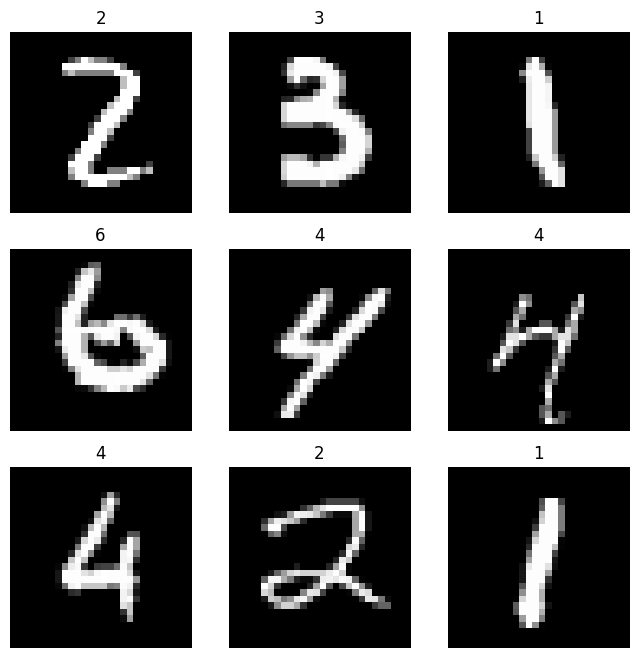

In [25]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [81]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f'shape X : {X.shape}')
    print(f'shape y : {y.shape}')
    print(type(y))
    break

shape X : torch.Size([64, 1, 28, 28])
shape y : torch.Size([64])
<class 'torch.Tensor'>


In [27]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [28]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims) - 1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x): # fait : 1 * 28 * 28 --> 1 * 784
        x = self.flatten(x)
        for layer in self.fcs:
            x = layer(x)
            x = self.act(x)
        return x

In [29]:
input_dim = 28*28
output_dim = 10

model = MLP([input_dim, 64, 64, output_dim])
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [30]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [31]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Prédiction
        ypred = model(X)
        loss = loss_fn(ypred, y)

        # Backpropag
        loss.backward()
        optimizer.step() # W = W - lr * grad
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            # print(f'loss {loss:>7f} [{current:>5d}/{len(dataloader.dataset)}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()

    test_loss/=len(dataloader)
    correct/= len(dataloader.dataset)
    print(f'Test loss : {test_loss:>8f} | test accuracy {(correct * 100):7f}')
    


In [32]:
epochs = 10
for t in range(epochs):
    continue
    print(f'Epoch {t+1} ----------------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done !")


Done !


# Jour 2

In [33]:
# Mean, Variance des images

from torch.utils.data import ConcatDataset

mean, std = 0, 0
combined_data = ConcatDataset([training_dataset, test_dataset])

for image, label in combined_data:
    image = image.view(28*28)
    mean+= image.mean().sum()
    std+= image.std().sum()

mean /= len(combined_data)
std /= len(combined_data)

print (f'Mean: {mean}')
print (f'Variance: {std}')

Mean: 0.13092496991157532
Variance: 0.30183959007263184


In [34]:
training_dataset2 = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

test_dataset2 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

# Mean, Variance des images

from torch.utils.data import ConcatDataset

mean, std = 0, 0
combined_data = ConcatDataset([training_dataset2, test_dataset2])

for image, label in combined_data:
    image = image.view(28*28)
    mean+= image.mean().sum()
    std+= image.std().sum()

mean /= len(combined_data)
std /= len(combined_data)

print (f'Mean: {mean}')
print (f'Variance: {std}')

Mean: 1.2540766647362034e-06
Variance: 0.9999989867210388


In [35]:
training_dataset2[0]

(tensor([[[-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338],
          [-0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338, -0.4338,
           -0.4338, -0.4338, -0.433

In [36]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader2 = DataLoader(training_dataset2, batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_dataset2, batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f'shape X : {X.shape}')
    print(f'shape y : {y.shape}')
    break

shape X : torch.Size([64, 1, 28, 28])
shape y : torch.Size([64])


In [37]:
epochs = 10
for t in range(epochs):
    continue
    print(f'Epoch {t+1} ----------------------------------')
    train_loop(train_dataloader2, model, loss_fn, optimizer)
    test_loop(test_dataloader2, model, loss_fn)

print("Done !")

Done !


In [57]:
# On améliore tout ça

device = "mps" if torch.mps.is_available() else "cpu"
model.to(device)

input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim]).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [58]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_1')


def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

#train_and_test(train_dataloader2, test_dataloader2, model, loss_fn, optimizer, epochs, batch_size)


In [59]:
# !tensorboard --logdir=runs/mnist_experiment_1

# Circonvolutions

In [68]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_stack_activation = nn.ReLU
        self.mlp_activation = nn.ReLU

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            self.conv_stack_activation(),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            self.conv_stack_activation(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 * 28 * 28 -> 64 * 14 * 14
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            self.mlp_activation(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            self.mlp_activation(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [69]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [70]:
writer = SummaryWriter('runs/mnist_experiment_2')

epochs = 10

train_and_test(train_dataloader2, test_dataloader2, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/10
Epoch 1/10 complete

Epoch 2/10
Epoch 2/10 complete

Epoch 3/10
Epoch 3/10 complete

Epoch 4/10
Epoch 4/10 complete

Epoch 5/10
Epoch 5/10 complete

Epoch 6/10
Epoch 6/10 complete

Epoch 7/10
Epoch 7/10 complete

Epoch 8/10
Epoch 8/10 complete

Epoch 9/10
Epoch 9/10 complete

Epoch 10/10
Epoch 10/10 complete



In [63]:
# !tensorboard --logdir=runs/mnist_experiment_2

TensorFlow installation not found - running with reduced feature set.
I0128 11:40:22.353121 6123122688 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [72]:
# Transformation pour avoir un modele exportable

cnn.to("cpu")

torch_input = torch.randn(1, 1, 28, 28) # N, C, L, T

onn_program = torch.onnx.export(
    cnn,
    torch_input,
    "model.onnx",
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=11, # /!\ 
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batchs_size"},
    }
)

Exported graph: graph(%input : Float(*, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv_stack.0.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.weight : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.running_mean : Float(64, strides=[1], requires_grad=0, device=cpu),
      %conv_stack.6.running_var : Float(64, strides=[1], requires_grad=0, device=cpu),
      %mlp.1.weight : Float(128, 12544, strides=[12544, 1], requires_grad=1, device=cpu),
      %mlp.1.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %mlp.4.weight : Float(

In [74]:
# Test it

import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[-1.2219e+00, -2.5367e-01,  6.8956e-01,  6.9917e-01, -1.2046e+00,
           -2.9086e-01,  1.4856e+00,  3.3892e-01, -4.9007e-01, -7.7641e-01,
            5.5521e-01, -2.2366e-01, -6.7772e-01, -3.5954e-01, -7.7353e-01,
           -5.5444e-01,  7.9168e-01,  4.9112e-01, -1.2879e-01, -6.2677e-01,
           -9.9835e-01, -1.2090e+00, -9.3111e-01, -2.7487e-01,  1.7910e+00,
            1.8780e-01,  8.0235e-01,  2.4094e+00],
          [-5.5647e-03,  1.1229e+00, -9.0257e-01, -9.1104e-02, -8.9972e-02,
            2.3331e-01, -7.0786e-01,  2.8732e+00,  9.0988e-01,  1.5263e+00,
           -1.8106e+00, -2.1439e-01,  1.2391e+00, -1.5240e+00, -1.1004e+00,
            1.1597e+00, -1.1166e+00,  1.3053e+00, -1.7253e+00,  1.2159e+00,
           -2.9961e-01,  1.5998e+00, -7.9291e-01,  3.4495e-01,  1.3541e+00,
            2.0128e-01,  8.1394e-01, -2.2371e-01],
          [ 1.6610e-01, -8.1934e-01, -1.0818e+00,  1.5761e+00, -9.1697e-01,
           -8.5459e-01,  4.9244

In [75]:
torch_outputs = cnn(torch_input)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [[ -9.016034  -11.120109    2.1615992  -1.6675048 -21.911633   -3.6054754
  -17.77668    -3.433702    6.6276264  -5.816256 ]]
